In [2]:
import os
import pathlib
import numpy as np
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from multiprocessing import Pool
import psutil
from climatenet.utils.data import ClimateDataset
from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
from climatenet.analyze_events import analyze_events
from climatenet.visualize_events import visualize_events
import torch
import numpy as np
from os import path
from sklearn.metrics import jaccard_score
from climatenet.procrustes_loss import ProcrustesLoss


config = Config('/home/sbk29/data/ClimateNet/config.json')
model = CGNet(config)

In [3]:
from torch.utils.data import Dataset, DataLoader
config = Config('/home/sbk29/data/ClimateNet/climatenet/config_new.json')
model = CGNet(config)
labeled_dataset = ClimateDatasetLabeled('/home/sbk29/data/AR/test', model.config)
loader = DataLoader(labeled_dataset, batch_size=1, collate_fn=ClimateDatasetLabeled.collate)
true_mask = []
# Iterate through all batches in the test loader
for batch_idx, (input_images, labels) in enumerate(loader):
    # Move data to the same device as the model
    # input_images = input_images.to(device)
    # labels = labels.to(device)
    true_mask.append(labels)



In [4]:
# config = Config('/home/sbk29/data/ClimateNet/climatenet/config_new.json')
# print(config.num_classes)  # should be 3
# cgnet = CGNet(config)


training_set = ClimateDatasetLabeled('/home/sbk29/data/AR/train', model.config)
inference_set = ClimateDataset('/home/sbk29/data/AR/test', model.config)

# local_state_dict = torch.load('/home/sbk29/data/ClimateNet/weights.pth', map_location="cuda", weights_only=True)

model.load_model('/home/sbk29/data/ClimateNet/climatenet/weights/')





In [5]:
predictions = model.predict(inference_set)
print(predictions.shape)

 12%|█▎        | 1/8 [00:01<00:10,  1.49s/it]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 25%|██▌       | 2/8 [00:02<00:06,  1.12s/it]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 38%|███▊      | 3/8 [00:03<00:05,  1.02s/it]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 50%|█████     | 4/8 [00:04<00:04,  1.03s/it]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 62%|██████▎   | 5/8 [00:05<00:03,  1.04s/it]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 75%|███████▌  | 6/8 [00:06<00:02,  1.05s/it]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


 88%|████████▊ | 7/8 [00:07<00:01,  1.06s/it]

Output shape : torch.Size([8, 2, 768, 1152])
(8, 2, 768, 1152)


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]

Output shape : torch.Size([5, 2, 768, 1152])
(5, 2, 768, 1152)


(61, 2, 768, 1152)


In [ ]:
config = Config('/home/sbk29/data/ClimateNet/climatenet/config_new.json')
# print(config.num_classes)  # should be 3
cgnet = CGNet(config)

train_path = '/home/sbk29/data/AR/'
train_dataset = ClimateDatasetLabeled(path.join(train_path, 'train'), config)
cgnet.train(train_dataset)

In [6]:
cgnet.save_model('/home/sbk29/data/ClimateNet/climatenet/weights/')

In [6]:
predictions = np.array(predictions)

In [7]:
true_mask = np.array(true_mask)


In [8]:
predictions.shape

(61, 2, 768, 1152)

In [23]:
predicted_mask = predictions[:,1,:,:] > 0.2

In [10]:
predicted_mask.shape

(61, 768, 1152)

In [11]:
np.unique(predicted_mask)

array([False,  True])

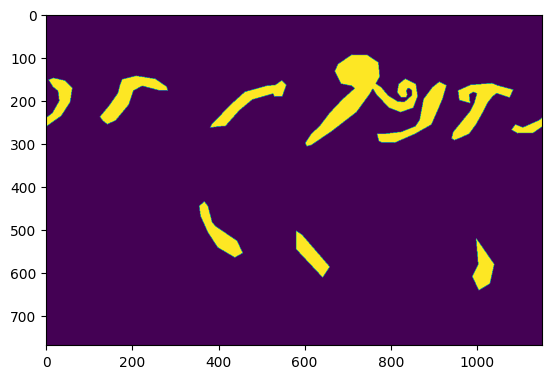

In [13]:
plt.imshow(true_mask[1,0,:,:])

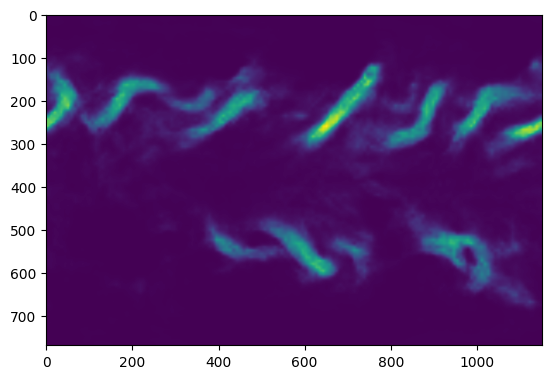

In [22]:
plt.imshow(predictions[1,1,:,:])

In [24]:
# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = true_mask.shape[0]
scores = []

for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = true_mask[i, 0, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask[i, :, :].ravel()  # shape (768*1152,)
    pred_flat = pred_flat.ravel()
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.3804366673715877


In [25]:
procrustes_loss_fn = ProcrustesLoss(
        threshold=0.5, allow_scaling=False, penalty_constant=500
    )

In [26]:
true_mask = torch.tensor(true_mask)
predicted_prob = torch.tensor(predictions)

In [27]:
procrustes_loss_fn(true_mask, predicted_prob)

tensor(123.8359)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_true_predicted(background_path, true_mask, predicted_mask, num_images=3, alpha=0.4):
    """
    Overlays true and predicted masks on a background image.

    Args:
        background_path (str): Path to the background image (e.g., 'BM.jpeg')
        true_mask (ndarray): Ground truth mask (B, H, W) or (B, 1, H, W)
        predicted_mask (ndarray): Predicted mask (B, H, W)
        num_images (int): Number of images to display
        alpha (float): Transparency of the mask overlay
    """
    # Load background image
    background = Image.open(background_path).convert('RGB')
    background = np.array(background)

    # Resize to match mask size if needed
    H, W = true_mask.shape[-2:]
    bg_resized = np.array(Image.fromarray(background).resize((W, H)))

    # Remove channel from true mask if needed
    if true_mask.ndim == 4:
        true_mask = true_mask[:, 0, :, :]

    plt.figure(figsize=(10, 5 * num_images))

    for i in range(num_images):
        # True mask overlay
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(bg_resized)
        plt.imshow(true_mask[i], cmap='Reds', alpha=alpha)
        plt.title(f"Overlay: True Mask {i}")
        plt.axis('off')

        # Predicted mask overlay
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(bg_resized)
        plt.imshow(predicted_mask[i], cmap='Blues', alpha=alpha)
        plt.title(f"Overlay: Predicted Mask {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [29]:
background = '/home/sbk29/data/ClimateNet/climatenet/bluemarble/BM.jpeg'

TypeError: Invalid shape (2, 768, 1152) for image data

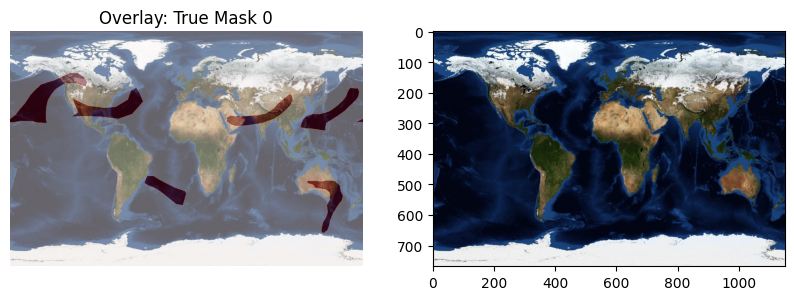

In [33]:
# Assume you have already computed true_mask and predicted_mask
plot_true_predicted(background, true_mask, predicted_mask, num_images=5)

In [44]:
import matplotlib.pyplot as plt

def plot_prediction_probs(predictions, class_idx=1, num_images=4, cmap='viridis'):
    """
    Plots class-specific probability maps from predictions.

    Args:
        predictions (ndarray or tensor): Shape (B, C, H, W)
        class_idx (int): Index of the class to visualize (e.g., 0 or 1)
        num_images (int): Number of samples to visualize
        cmap (str): Colormap to use (e.g., 'viridis', 'plasma', 'hot')
    """
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()

    plt.figure(figsize=(10, 3 * num_images))

    for i in range(num_images):
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(predictions[i, class_idx, :, :], cmap=cmap)
        # plt.colorbar()
        plt.title(f"Sample {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


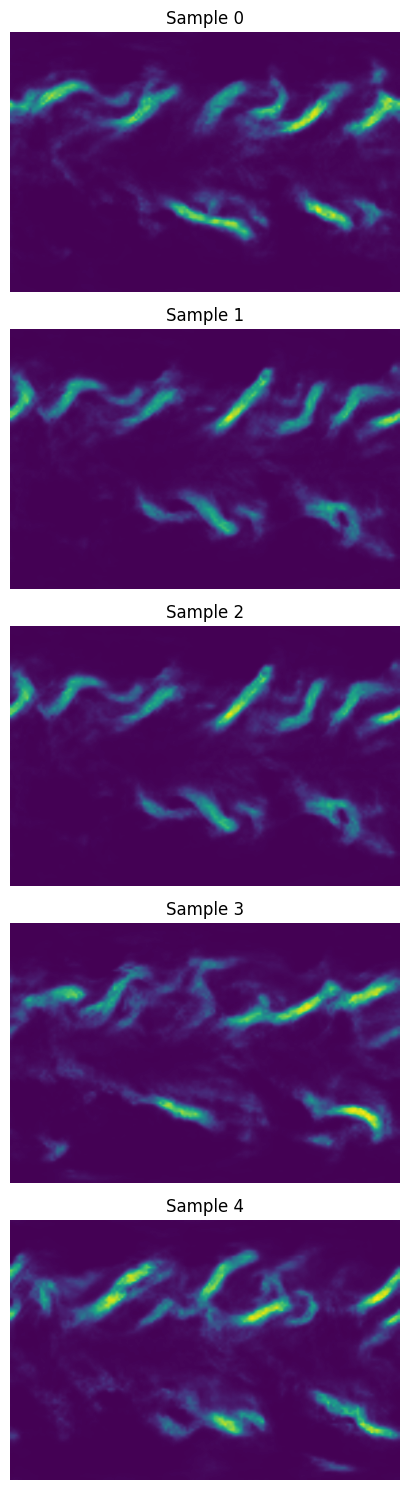

In [45]:
# predictions: shape (B, C, H, W), values ∈ [0, 1] after softmax
plot_prediction_probs(predictions, class_idx=1, num_images=5)


In [50]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

def plot_masks_on_background(true_mask, predictions, background_path, class_idx=1, num_images=5, cmap='viridis', alpha=0.5):
    """
    Overlays true masks and predicted probabilities on a Blue Marble background image.

    Args:
        true_mask (tensor/ndarray): Shape (B, H, W) or (B, 1, H, W)
        predictions (tensor/ndarray): Shape (B, C, H, W)
        background_path (str): Path to the background image (e.g., 'BM.jpeg')
        class_idx (int): Class to visualize from predictions
        num_images (int): Number of samples to plot
        cmap (str): Colormap for predicted probabilities
        alpha (float): Transparency of overlays
    """
    # Convert to numpy if tensors
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(true_mask, torch.Tensor):
        true_mask = true_mask.detach().cpu().numpy()

    # Remove channel dim from true mask if present
    if true_mask.ndim == 4:
        true_mask = true_mask[:, 0, :, :]

    # Load and resize background image
    bg_img = Image.open(background_path).convert('RGB')
    H, W = true_mask.shape[-2:]
    bg_img = bg_img.resize((W, H))
    bg_np = np.array(bg_img)

    plt.figure(figsize=(12, 4 * num_images))

    for i in range(num_images):
        # Plot true mask on Blue Marble
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(bg_np)
        plt.imshow(true_mask[i], cmap='gray', alpha=alpha)
        plt.title(f"True Mask Sample {i}")
        plt.axis("off")

        # Plot prediction probs on Blue Marble
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(bg_np)
        plt.imshow(predictions[i, class_idx, :, :], cmap=cmap, alpha=alpha)
        plt.title(f"Predicted Prob of AR - Sample {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


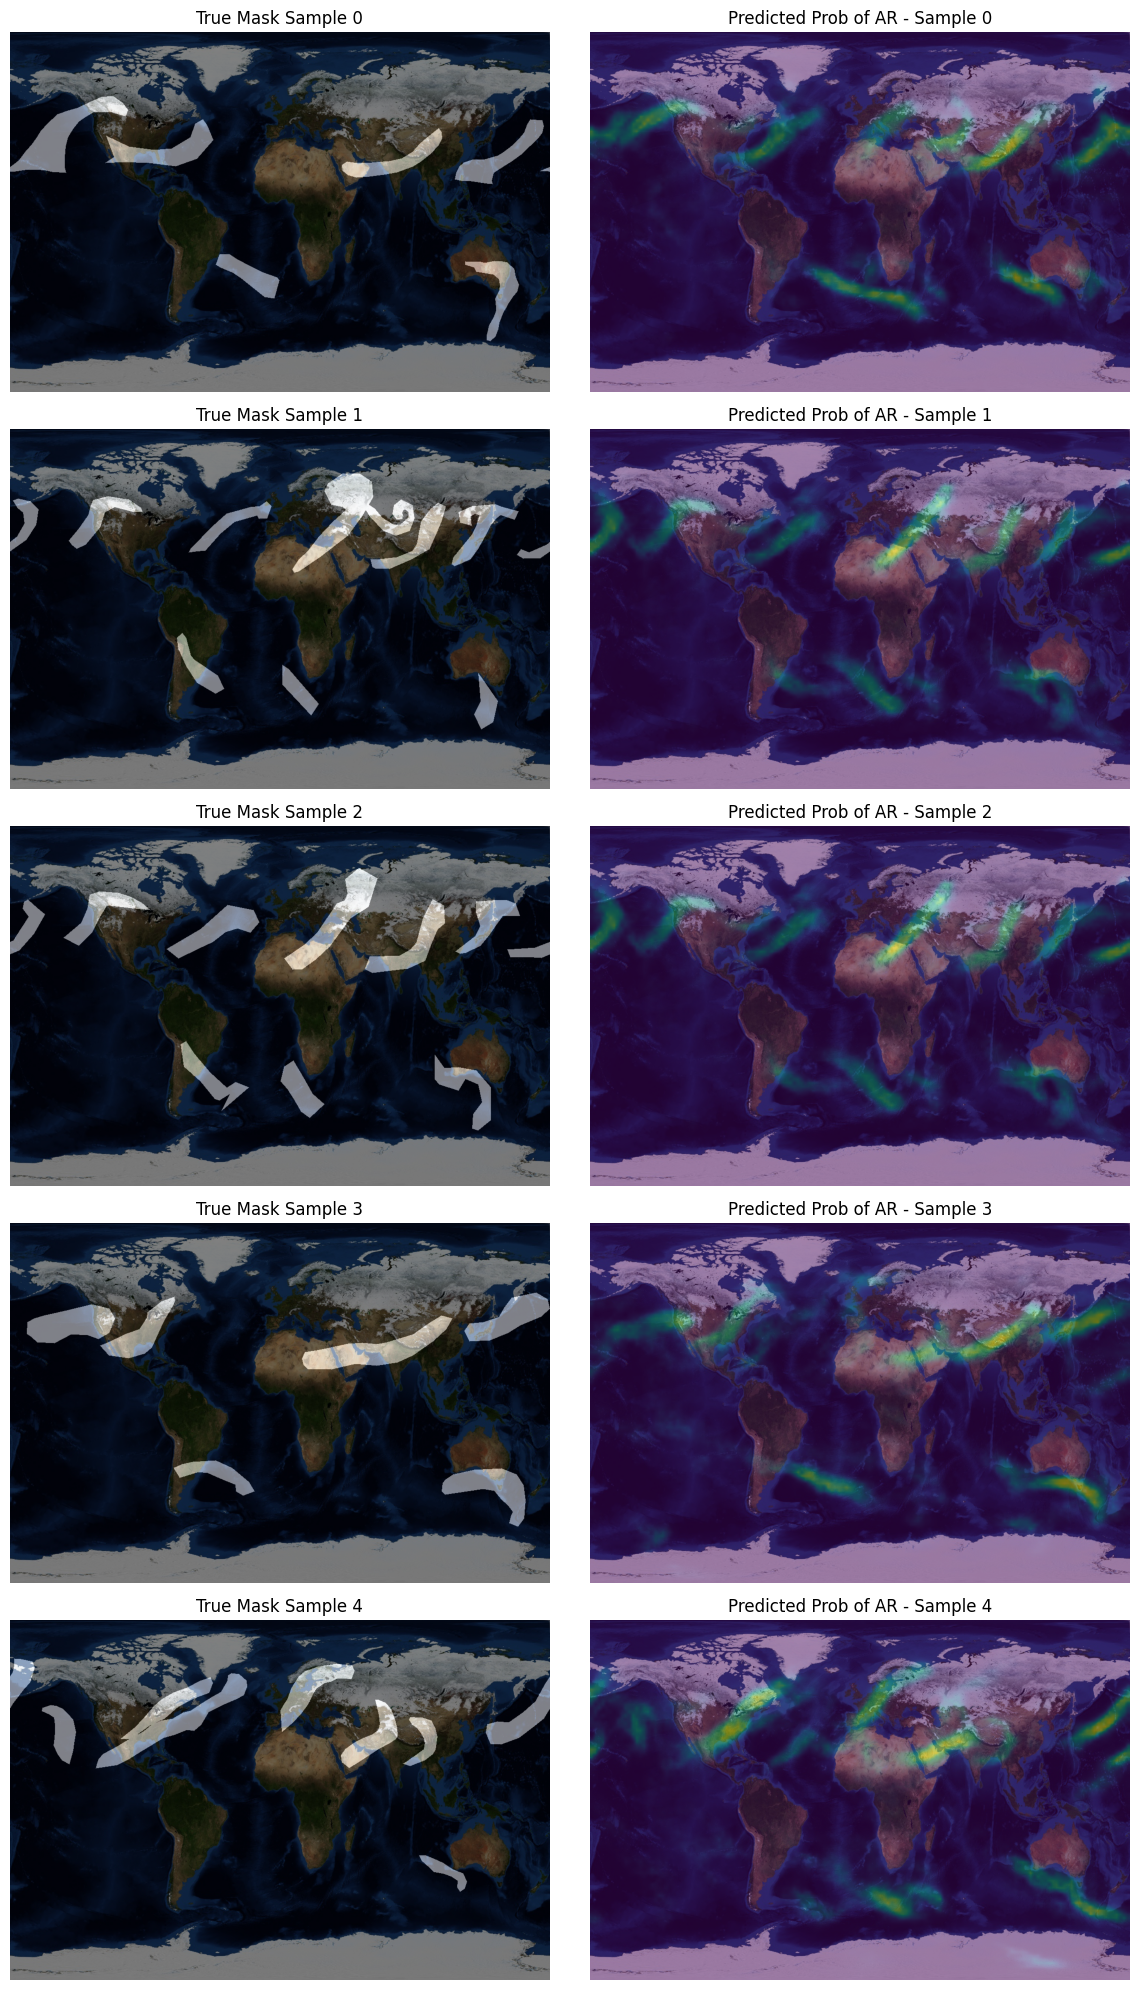

In [51]:
plot_masks_on_background(true_mask, predictions, background_path='/home/sbk29/data/ClimateNet/climatenet/bluemarble/BM.jpeg', class_idx=1, num_images=5)

